## 导入必要的安装包

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import os 
from tqdm import tqdm
import glob
ts.set_token('ce1d8f98f48f0c92fa70a66528612510f350b82ea565bc1abd45b5ac')
debug = False
from datetime import datetime 
pro = ts.pro_api()

In [2]:
# !pip install openpyxl

## 生成Alpha因子的基础函数

In [3]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 


## 一系列Alpha因子

In [4]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
        alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
        alpha_dict['alpha_total_mv']= daily_info['total_mv']
        alpha_dict['alpha_pb']= -1*daily_info['pb']
        alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
        alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
        alpha_dict['alpha_vwap']= daily_info['vwap']
        alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']
        return alpha_dict
        

## 生成训练集

In [5]:
pro = ts.pro_api()
all_stock = pro.stock_basic()
price_PD_total = pd.read_csv('data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = all_stock[['ts_code','name','market','industry']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

In [6]:

daily_basic = pd.read_csv('data/daily_basic.csv', dtype = {'trade_date': 'str'})
daily_basic

,ts_code,trade_date,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,000001.SZ,20190102,0.3141,0.7088,0.99,6.8048,6.4428,0.7330,1.4917,1.4012,1.4799,1.4799,1.717041e+06,1.717025e+06,761029.0923,1.577961e+07,1.577946e+07
1,000001.SZ,20190103,0.2420,0.5460,0.76,6.8714,6.5059,0.7402,1.5063,1.4149,1.4655,1.4655,1.717041e+06,1.717025e+06,761029.0923,1.593414e+07,1.593399e+07
2,000001.SZ,20190104,0.8626,1.9463,2.87,7.2194,6.7456,0.7607,1.5825,1.4343,1.3949,1.3949,1.717041e+06,1.717025e+06,761029.0923,1.674115e+07,1.674099e+07
3,000001.SZ,20190107,0.5042,1.1375,1.19,7.2120,6.7386,0.7599,1.5809,1.4329,1.3963,1.3963,1.717041e+06,1.717025e+06,761029.0923,1.672398e+07,1.672382e+07
4,000001.SZ,20190108,0.2344,0.5287,0.52,7.1528,6.6833,0.7536,1.5679,1.4211,1.4079,1.4079,1.717041e+06,1.717025e+06,761029.0923,1.658662e+07,1.658646e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718158,920128.BJ,20250122,5.5613,5.5613,0.87,50.1866,48.6791,4.2442,3.9764,3.7950,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.277380e+05,4.796550e+04
6718159,920128.BJ,20250123,5.8266,5.8266,1.02,49.9898,48.4882,4.2276,3.9608,3.7802,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.268449e+05,4.777740e+04
6718160,920128.BJ,20250124,3.9659,3.9659,0.74,49.7393,48.2453,4.2064,3.9409,3.7612,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.257082e+05,4.753800e+04
6718161,920128.BJ,20250127,3.0706,3.0706,0.61,49.6856,48.1932,4.2018,3.9367,3.7572,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.254646e+05,4.748670e+04


In [7]:
price_PD_total = pd.merge(price_PD_total,daily_basic,how='left',on=['ts_code','trade_date'])


In [8]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [9]:
#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1) 
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1) 
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [10]:

daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='open')
daily_info['close'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='close')
daily_info['high']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='high')
daily_info['low']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='low')
daily_info['volume']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='vol')
daily_info['amount']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 
daily_info['pe_ttm']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='pe_ttm')
daily_info['total_mv']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='total_mv')
daily_info['pb']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='pb')
daily_info['turnover_rate']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='turnover_rate')
daily_info['volume_ratio']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='volume_ratio')
daily_info['dv_ttm']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='dv_ttm')


In [11]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [12]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:49<00:00,  3.42s/it]


In [13]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [14]:
price_PD_total.columns

Index(['ts_code', 'name', 'market', 'industry', 'trade_date', 'open', 'high',
       'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount',
       'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe', 'pe_ttm',
       'pb', 'ps', 'ps_ttm', 'dv_ratio', 'dv_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'open_up', 'ret1',
       'ret2', 'ret'],
      dtype='object')

In [15]:
data = data[~data.alpha_vwap.isna()].reset_index(drop=True)


In [16]:
train = data.copy()
train = train[train.trade_date < '20240101']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

from sklearn.model_selection import KFold,GroupKFold,train_test_split

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

enumsplit = []
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
    enumsplit.append([trn_ind, val_ind])  
enumsplit

[[array([      1,       3,       4, ..., 4587190, 4587191, 4587192]),
  array([      0,       2,       8, ..., 4587176, 4587177, 4587180])],
 [array([      0,       2,       4, ..., 4587189, 4587190, 4587192]),
  array([      1,       3,       5, ..., 4587186, 4587187, 4587191])],
 [array([      0,       1,       2, ..., 4587189, 4587190, 4587191]),
  array([     11,      20,      33, ..., 4587185, 4587188, 4587192])],
 [array([      0,       1,       2, ..., 4587188, 4587191, 4587192]),
  array([      6,      14,      16, ..., 4587173, 4587189, 4587190])],
 [array([      0,       1,       2, ..., 4587190, 4587191, 4587192]),
  array([      4,      10,      15, ..., 4587162, 4587164, 4587168])]]

In [17]:
train.columns

Index(['ts_code', 'trade_date', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
       'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
       'alpha_dv_ttm', 'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [18]:
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
       'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
       'alpha_dv_ttm']


In [19]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())


In [20]:
test = data.copy()
test = test[test.trade_date > '20240101']
test.replace([np.inf, -np.inf], np.nan,inplace=True)
test[features] = test[features].fillna(train[features].mean())


## 模型训练

In [21]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
import numpy as np
from keras import backend as K


In [22]:
from keras.backend import sigmoid


hidden_units = (128,64,32)


def base_model():
    
    num_input = keras.Input(shape=(len(features),), name='num_data')

    out = num_input
    for n_hidden in hidden_units:

#         out = keras.layers.Dense(n_hidden, activation='relu')(out)
        out = keras.layers.Dense(n_hidden)(out)

    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = num_input,
    outputs = out,
    )
    model.compile(
        optimizer=tf.optimizers.Adam(1e-2),
        loss='mse',
        metrics=[keras.metrics.mse]
    )
    return model


In [23]:
model = base_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 num_data (InputLayer)       [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 prediction (Dense)          (None, 1)                 33        
                                                                 
Total params: 14593 (57.00 KB)
Trainable params: 14593 (57.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from sklearn.preprocessing import QuantileTransformer

train_nn=train[features].copy()
test_nn=test[features].copy()
qt_train = []
for col in features:
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])
    qt_train.append(qt)

In [25]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

In [26]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']
# y = train['ret']

oof_predictions = np.zeros(train.shape[0])

for fold, (trn_ind, val_ind) in enumerate(enumsplit):
    print(f'Training fold {fold + 1}')
    x_train, x_val = train_nn.iloc[trn_ind][features], train_nn.iloc[val_ind][features]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    
    model = base_model()

    model.fit(x_train, 
              y_train,               
              batch_size=2048,
              epochs=5,
              validation_data=(x_val, y_val),
              callbacks=[es, plateau],
              validation_batch_size=len(y_val),
              shuffle=True,
              verbose = 1)

    
    modellist.append(model)
    oof_predictions[val_ind] = model.predict(x_val).reshape(1,-1)[0]
    
    print(f'fold RMSPE is {mean_squared_error(y_val, oof_predictions[val_ind])**0.5}')
    corrr_score = np.corrcoef([y_val, oof_predictions[val_ind]])[0,1]
    print(f'fold CORR is {corrr_score}')

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f'Our out of folds RMSPE is {rmspe_score}')
corrr_score = np.corrcoef([y, oof_predictions])[0,1]
print(f'Our out of folds CORR is {corrr_score}')

Training fold 1
Epoch 1/5
1792/1792 [==============================] - 10s 5ms/step - loss: 0.1119 - mean_squared_error: 0.1119 - val_loss: 0.0835 - val_mean_squared_error: 0.0835 - lr: 0.0100
Epoch 2/5
1792/1792 [==============================] - 8s 5ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - lr: 0.0100
Epoch 3/5
1792/1792 [==============================] - 8s 5ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - val_loss: 0.0836 - val_mean_squared_error: 0.0836 - lr: 0.0100
Epoch 4/5
1792/1792 [==============================] - 8s 5ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - lr: 0.0100
Epoch 5/5
28670/28670 [==============================] - 27s 925us/step
fold RMSPE is 0.28851294575973513
fold CORR is 0.054041082190773096
Training fold 2
Epoch 1/5
1792/1792 [==============================] - 9s 5ms/step - loss: 0.1118 - mean_squared_error: 0.1118 - val_loss: 

## 分组法测有效性

In [27]:

pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test_nn[features]).reshape(1,-1)[0]
test['pred'] = pred
date_calc = sorted(test.trade_date.unique())



35700/35700 [==============================] - 33s 917us/step


In [28]:
test = pd.merge(test,all_stock[['ts_code','industry']],how='left',on='ts_code')

test['factor_rank'] = test.groupby(['trade_date','industry']).pred.rank(pct=True,method='dense')

def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)
    
test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [29]:
test.factor_rank_bin.value_counts()

10    129819
6     118185
3     116921
9     116129
7     115175
8     113429
2     112639
4     111685
5     111087
1      97329
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

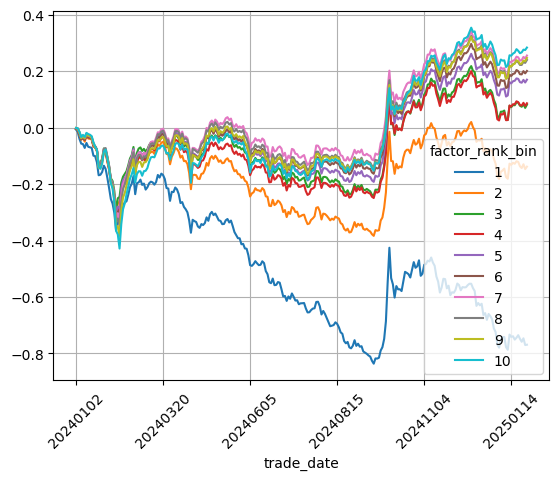

In [30]:
(test.groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<AxesSubplot:xlabel='trade_date'>

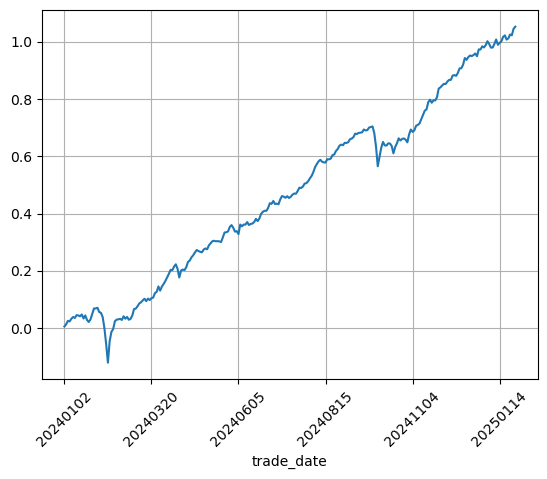

In [31]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (test[(test.factor_rank_bin == 10)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [32]:
ret_PD = (test.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [33]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end



 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.745443,-1.985559,0.023650,0.429119,-0.835136
1,2,-0.134092,-0.378083,0.022342,0.490421,-0.380181
2,3,0.078427,0.226510,0.021811,0.513410,-0.292172
3,4,0.083423,0.239411,0.021950,0.505747,-0.322949
4,5,0.164457,0.477963,0.021675,0.528736,-0.312146
5,6,0.194491,0.566172,0.021640,0.521073,-0.321540
6,7,0.247394,0.715232,0.021789,0.532567,-0.324975
7,8,0.232077,0.667725,0.021894,0.528736,-0.347124
8,9,0.239054,0.682292,0.022071,0.544061,-0.382980
9,10,0.274755,0.774476,0.022348,0.551724,-0.427818


## 固定买入N支

<AxesSubplot:title={'center':'2022-2024 year'}, xlabel='trade_date'>

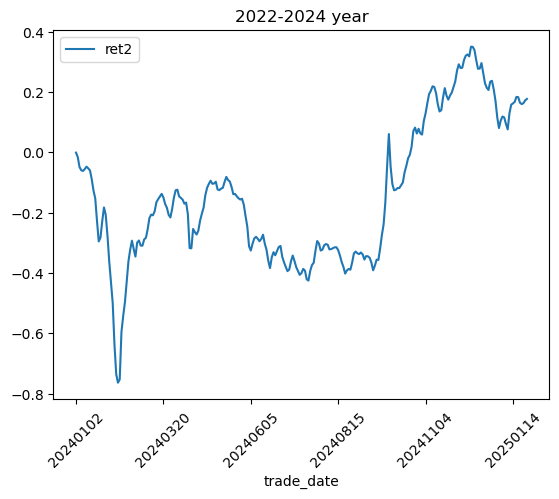

In [35]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp[~tmp.alpha_vwap.isna()].reset_index(drop=True)
# tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)] 
num = 300
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0005)
(ret_pd1.loc['20220101':,] ).cumsum().plot(rot=45, title = '2022-2024 year')


In [36]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()
    
    ret2_len = pd.DataFrame(tmp.groupby('trade_date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    
    

    return performance

In [37]:
calc_pfmc(ret_pd1) #0.006355

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.172808,0.334275,0.032566,0.517241,-0.763146


## 对冲收益

In [38]:
## 计算对冲的收益
dfindex = pro.index_daily(ts_code='000852.SH', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])   #zz1000
# dfindex = pro.index_daily(ts_code='399905.SZ', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])  #zz500
dfindex = dfindex[['trade_date','pct_chg']].set_index('trade_date').sort_index()
dfindex

,pct_chg
trade_date,
20240102,-0.5518
20240103,-0.5245
20240104,-0.7044
20240105,-1.8538
20240108,-2.3298
...,...
20250122,-0.8850
20250123,-0.4561
20250124,1.8716


In [39]:
ret_pd_concat = pd.merge(ret_pd1,dfindex/100,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','dfindex']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['dfindex']
ret_pd_concat

,ret,dfindex,diff
trade_date,,,
20240102,-0.000429,-0.005518,0.005089
20240103,-0.014846,-0.005245,-0.009601
20240104,-0.032900,-0.007044,-0.025856
20240105,-0.010793,-0.018538,0.007745
20240108,-0.002225,-0.023298,0.021073
...,...,...,...
20250122,0.003226,-0.008850,0.012076
20250123,0.009356,-0.004561,0.013917
20250124,0.004612,0.018716,-0.014104


In [40]:
ret_pd_concat.corr()

,ret,dfindex,diff
ret,1.000000,0.123203,0.820932
dfindex,0.123203,1.000000,-0.465534
diff,0.820932,-0.465534,1.000000


<AxesSubplot:title={'center':'2022-2024 year'}, xlabel='trade_date'>

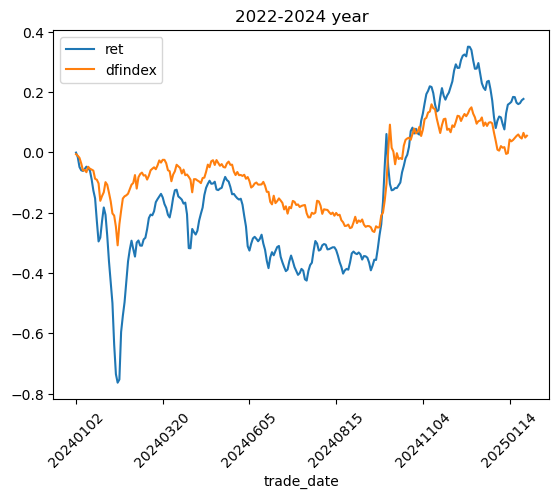

In [41]:
(ret_pd_concat[['ret','dfindex']].cumsum()).plot(rot=45, title = '2022-2024 year')


In [42]:
calc_pfmc(ret_pd_concat[['diff']]) 

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.1095,0.188902,0.036516,0.498084,-0.523429
